# Multiple Objects

A real analysis rarely deals with single objects - just one electron or one jet. More common are combinations of objects. The `hep_tables` package does this by leaning on the `map` function previously described and python's captured variables.

In [1]:
from hep_tables import xaod_table, make_local, curry
from dataframe_expressions import user_func, define_alias
from func_adl import EventDataset
import matplotlib.pyplot as plt

import numpy as np

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Define DeltaR function availible on servicex (see the functions intro for more info)
@user_func
def DeltaR(p1_eta: float, p1_phi: float, p2_eta: float, p2_phi: float) -> float:
    '''
    Calculate the DeltaR between two particles given their `eta` and `phi` locations.
    Implemented on the back end.
    '''
    assert False, 'This should never be called'
    
define_alias('', 'ptgev', lambda o: o.pt / 1000.0)

import logging
logging.getLogger('urllib3.connectionpool').setLevel(logging.WARNING)

In [2]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')
df = xaod_table(dataset)

## Matching the MC electron to the actual electron

We need to look at the MC particles, select the electrons, and then match them to electrons in the actual dataset. I've not done this in this dataset before, so I'm going to have to feel my way a bit with a few plots to allow me to understand what is going on.

First, lets get a plot of the MC electrons. I had to look up the pdg id (embarassing): `11` - Note that -11 isn't being used here because of a bug that this turned up in the backend (see [bug](https://github.com/iris-hep/func_adl_xAOD/issues/37))!

In [3]:
mc_part = df.TruthParticles('TruthParticles')
mc_ele = mc_part[(mc_part.pdgId == 11)]

In [4]:
mc_ele_pt = make_local(mc_ele.ptgev)
mc_ele_eta = make_local(mc_ele.eta)
mc_ele_phi = make_local(mc_ele.phi)

In [5]:
eles = df.Electrons('Electrons')

In [6]:
%%time
ele_pt = make_local(eles.ptgev)
ele_eta = make_local(eles.eta)
ele_phi = make_local(eles.phi)



Wall time: 4min 2s


i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


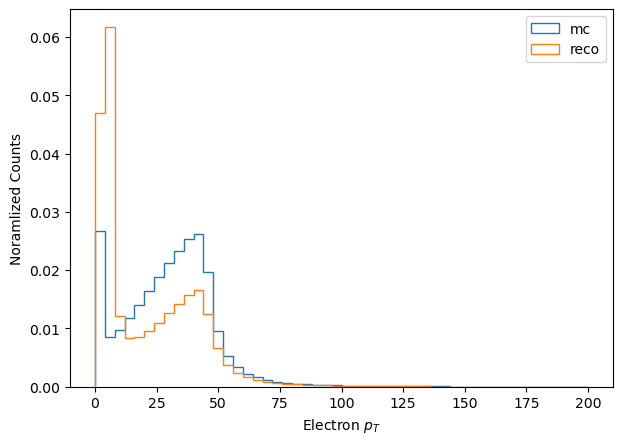

In [7]:
plt.hist(mc_ele_pt.flatten(), label='mc', bins=50, range=(0.0, 200.0), density=True, histtype='step')
plt.hist(ele_pt.flatten(), label='reco', bins=50, range=(0.0, 200.0), density=True, histtype='step')
plt.legend()
plt.xlabel('Electron $p_T$')
_ = plt.ylabel('Noramlized Counts')

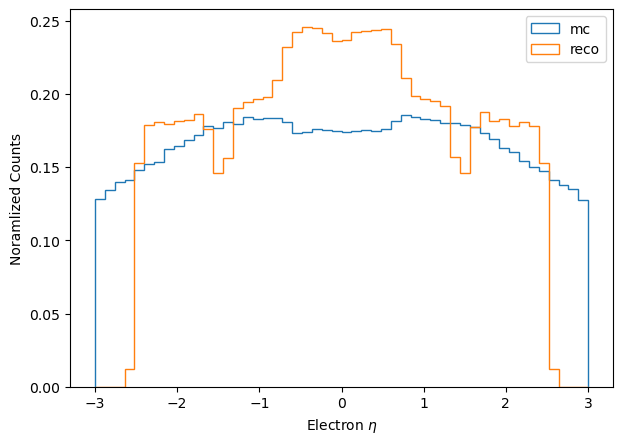

In [8]:
plt.hist(mc_ele_eta.flatten(), label='mc', bins=50, range=(-3.0, 3.0), density=True, histtype='step')
plt.hist(ele_eta.flatten(), label='reco', bins=50, range=(-3.0, 3.0), density=True, histtype='step')
plt.legend()
plt.xlabel('Electron $\eta$')
_ = plt.ylabel('Noramlized Counts')

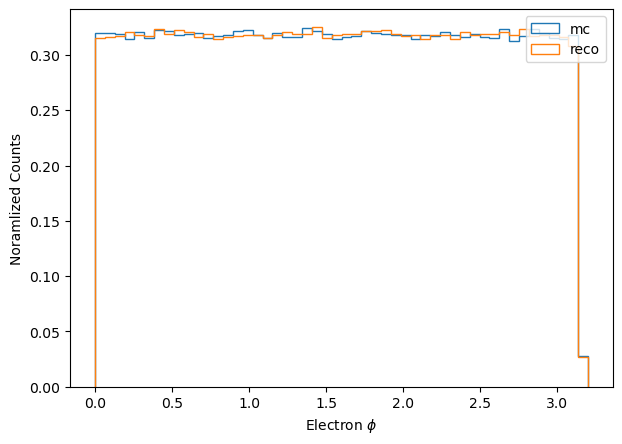

In [9]:
plt.hist(mc_ele_phi.flatten(), label='mc', bins=50, range=(0.0, 3.2), density=True, histtype='step')
plt.hist(ele_phi.flatten(), label='reco', bins=50, range=(0.0, 3.2), density=True, histtype='step')
plt.legend()
plt.xlabel('Electron $\phi$')
_ = plt.ylabel('Noramlized Counts')

From these plots, lets define good electrons as the following:

In [10]:
good_mc_ele = mc_ele[(mc_ele.ptgev > 20) & (abs(mc_ele.eta) < 1.5)]
good_eles = eles[(eles.ptgev > 20) & (abs(eles.eta) < 1.5)]

Now lets look at the DeltaR between the electron MC's and look at that. We have to work around one lack of a feature in the current system - no way to sort.

In [11]:
def dr (e, mc):
    'Make calculating DR easier as I have a hard-to-use DR calculation function on the back end'
    return DeltaR(e.eta(), e.phi(), mc.eta(), mc.phi())

@curry
def near(mcs, e):
    'Return all particles in mcs that are DR less than 0.5'
    return mcs[lambda m: dr(e, m) < 0.5]

# This gives us a list of events, and in each event, good electrons, and then for each good electron, all good MC electrons that are near by
ele_mcs = good_eles.map(near(good_mc_ele))

Lets see how this does - lets do a `Count` - which will return the number of MC particles close to each electron. `ele_mcs` is a list, with one entry for each event. In that entry, there is another list, with one entry for each electron. And in that entry, is a list for all MC electrons near by. If we want to count the contents of that last list, we need to apply the `Count` operator to it. This requires a `map`, as you'll see below.

Also, I had some trouble getting this statement to work properly - as a result I turned on logging. You can see what it is sending to `servicex` behind your back using this. Left on as it is interesting, but not useful unless you are trying to understand how your expression is being translated.

In [12]:
%%time
count_of_mc_near_each_e = make_local(ele_mcs.map(lambda e: e.Count()))



Wall time: 1.26 s


Text(0.5, 0, 'Number MC electrons near a RECO Electron')

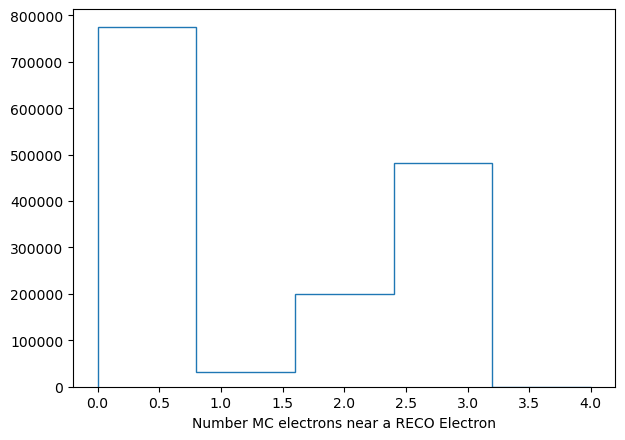

In [13]:
plt.hist(count_of_mc_near_each_e.flatten(), range=(0,4), bins=5, histtype='step')
plt.xlabel('Number MC electrons near a RECO Electron')

Those zeros are very odd. It could be I have a bug in my backend/servicex implementation somewhere. I'd really like to look at a histogram of $Delta R$ - however due to a limitation in the `servicex` backend currently, it isn't possible (it does not return 2D arrays). Lets redo this, but with tighter cut on delta R.

In [14]:
@curry
def very_near(mcs, e):
    'Return all particles in mcs that are DR less than 0.5'
    return mcs[lambda m: dr(e, m) < 0.1]

# This gives us a list of events, and in each event, good electrons, and then for each good electron, all good MC electrons that are near by
ele_neary_mcs = good_eles.map(very_near(good_mc_ele))

In [15]:
count_of_mc_very_near_each_e = make_local(ele_neary_mcs.map(lambda e: e.Count()))

Text(0.5, 0, 'Number MC electrons near a RECO Electron')

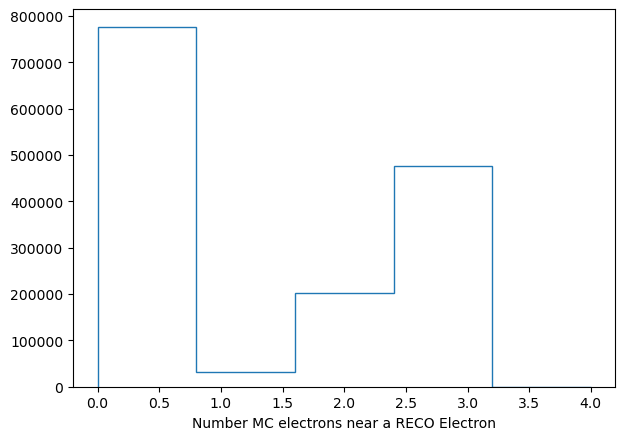

In [16]:
plt.hist(count_of_mc_very_near_each_e.flatten(), range=(0,4), bins=5, histtype='step')
plt.xlabel('Number MC electrons near a RECO Electron')

Refering to things this way is rather painful - that map. Instead, lets extend the good electron datamodel to help us out:

In [ ]:
good_eles['near_mcs'] = good_eles.map(very_near(good_mc_ele))

In [ ]:
count_of_mc_very_near_each_e_v2 = make_local(good_eles.near_mcs.Count())

In [ ]:
plt.hist(count_of_mc_very_near_each_e_v2.flatten(), range=(0,4), bins=5, histtype='step')
plt.xlabel('Number MC electrons near a RECO Electron')

In [ ]:
good_eles['hasMC'] = good_eles.near_mcs.Count() > 0
good_eles_with_mc = good_eles[good_eles.hasMC]
good_eles_with_mc['mc'] = good_eles_with_mc.near_mcs.First()

In [ ]:
pts_with = make_local(good_eles[good_eles.hasMC].pt)
pts_without = make_local(good_eles[not good_eles.hasMC].pt)

In [ ]:
resolution = make_lcoal(good_eles_with_mc.pt - good_eles_with_mc.mc.pt)

In [ ]:
plt.hist(resolution)